# Word Vectors and Lexical Semantics

## How to represent Words

* Natural language text = sequences of discrete symbols 이산 기호들의 배열(시퀀스)

* Navie representaion: one hot vectors $\in$ $R^{vocabulary}$, one hot 인코딩된 벡터들로 표현 아주큼


In [1]:
words = ['딥마인드', '워드', '벡터']
df = pd.DataFrame(np.eye(len(words)), index=words, dtype=np.int)
df

,0,1,2
딥마인드,1,0,0
워드,0,1,0
벡터,0,0,1


* Classical IR: document and query vectors are superpositions of word vectors
$$\hat{d_q}=\underset{d}{\arg \max} \sim(d,q)$$

* Similarly for word classification problems(e.g. Navie Bayes topic models)

* Issues: sparse, orthogonal representations, semantically weak

## Semantic similarity 의미론적 유사성
* 더 풍부하게 단어를 표현하고 싶다!!
* Distributional semantics: 분산 의미론
    * Idea: produce dense vector representations based on the contex/use of words
    * Approaches:
        * count-based
        * predictive
        * task-based

### Count-based methods
Define a basis vocabulary C of context words 
* 고를 때는 linguistic intutition(언어적 직관, 주관적인) / statistics of the corpus 에 의해 고름
* 이것을 하는 이유는 a, the 같은 의미와 무관한 function word를 포함시키지 않기 위함

Define a word window size $w$.

Count the basis vocabulary words occurring $w$ words to the left or right of each instance of a target word in the corpus

From a vector representation of the target word based on these counts

Example:

In [2]:
from collections import Counter, defaultdict
from operator import itemgetter

def get_vocabulary_dict(contexts, stopwords):
    vocabulary = Counter()
    for sentence in contexts:
        words = [word for word in sentence.split() if word not in stopwords] 
        vocabulary.update(words)
    return vocabulary

def represent_vector(contexts_words, vocabulary):
    vocab_len = len(vocabulary)
    word2idx = {w: i for i, w in enumerate(vocabulary)}
    count_based_vector = defaultdict()

    for key_word, context_w in contexts_words.items():
        temp = np.zeros(vocab_len, dtype=np.int)
        for w in context_w:
            temp[word2idx[w]] += 1
        count_based_vector[key_word] = temp
    return count_based_vector, word2idx

contexts = ['and the cute kitten purred and then',
            'the cute furry cat purred and miaowed',
            'that the small kitten miaowed and she',
            'the loud furry dog ran and bit']
stopwords=['and', 'then', 'she', 'that', 'the', 'cat', 'dog', 'kitten']
contexts_words = {'kitten': {'cute', 'purred', 'small', 'miaowed'},
                  'cat': {'cute', 'furry', 'miaowed'},
                  'dog': {'loud', 'furry', 'ran', 'bit'}}

vocabulary = get_vocabulary_dict(contexts, stopwords)
count_based_vector, word2idx = represent_vector(contexts_words, vocabulary)

In [3]:
word_idx_list = [w for i, w in sorted([(i, w) for w, i in word2idx.items()], key=itemgetter(0))]
df = pd.DataFrame(count_based_vector, index=word_idx_list)
df.T

,cute,purred,furry,miaowed,small,loud,ran,bit
cat,1,0,1,1,0,0,0,0
dog,0,0,1,0,0,1,1,1
kitten,1,1,0,1,1,0,0,0


Compare as similarity kernel:
$cosine(u, v) = \dfrac{u\cdot v}{\|u\|\times\|v\|}$

In [31]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [5]:
print('kitten-cat:', cosine(df['kitten'], df['cat']))
print('kitten-dog:',cosine(df['kitten'], df['dog']))
print('cat-dog:',cosine(df['cat'], df['dog']))

kitten-cat: 0.57735026919
kitten-dog: 0.0
cat-dog: 0.288675134595


Count-based method는 Navie Approach으로 접근

Not all features are equal: we must distinguish counts that are high, because they are informative from those that are just independently frequent contexts.

Many Normalisation methods: TF-IDF, PMI, etc

Some remove the need for norm-invariant similarity metrics

But... perhaps there are easier ways to address this problem of count-based mothods(and others, e.g. choice of basis context)

### Neural Embedding Models
Learning count based vecotrs produces an embedding matrix in $R^{|vocab|\times|context|}$

In [50]:
df.T  # df = E

,cute,purred,furry,miaowed,small,loud,ran,bit
cat,1,0,1,1,0,0,0,0
dog,0,0,1,0,0,1,1,1
kitten,1,1,0,1,1,0,0,0



Rows are word vectors, so we can retrieve them with one hot vectors in $\{0,1\}^{|vocab|}$

$$onehot_{cat} = \begin{bmatrix} 0 \newline 1 \newline 0 \end{bmatrix}, cat=onehot_{cat}^TE$$

Symbols = unique vectors. Representation = embedding symbols with $E$

(One) generic(포괄적인) idea behind embedding learning:
1. Collect instances $t_i \in inst(t)$ of a word $t$ of vocab $V$
2. For each instance, collect its context words $c(t_i)$ (e.g. k-word window)
3. Define some score function $score(t_i, c(t_i); \theta, E)$ with upper bound on output
4. Define a loss: 
$$L=-\sum_{t\in V}\sum_{t_i \in inst(t)}score(t_i, c(t_i);\theta,E)$$
5. Estimate:
$$\hat{\theta}, \hat{E}=\underset{\theta, E}{\arg \min}\ L$$
6. Use the estimated $E$ as your embedding matrix


* the generic algorithm will explore various instances of in the form of the collobert and weston 2011 embeddings word Tyvek models



Problems: Scoring function

Easy to design a useless scorer(e.g. ignore input, output upper bound)

Implicitly define is useful

Ideally, scorer:
* Embeds $t_i$ with $E$
* Produces a score which is a function of how well $t_i$ is accounted for by $c(t_i)$, and/or vice versa
* Requires the word to account for the context(or the reverse) more than another word in the same place.
* Produces a loss which is differentiable w.r.t. $\theta$ and $E$


#### C&W(Collobert et al. 2011)
[paper](http://www.jmlr.org/papers/volume12/collobert11a/collobert11a.pdf)

Interpretation: representations carry information about what neighbouring representations should look like

where it belongs? 같은 정보를 포함

#### CBoW (Mikolov et al. 2013)
[paper](https://arxiv.org/abs/1301.3781)

Embed context words. Add them.

Project back to vocabulary size. Softmax.
$$softmax(l)_i=\dfrac{e^{l_i}}{\sum_{j}e^{l_i}}$$
$$\begin{eqnarray} P(t_i|context(t_i) & = & softmax(\sum_{t_j\in context(t_i)} onehot_{t_j}^{t}\cdot E\cdot W_v) \newline
& = & softmax((\sum_{t_j\in context(t_i)} onehot_{t_j}^{t}\cdot E)\cdot W_v) \end{eqnarray}$$

Minimize Negative Log Likelihood:
$$L_{data} = -\sum_{t_i \in data}\log P(t_i|context(t_i))$$

장점: 
* All linear, so very fast. Basically a cheap way of applying one matrix to all inputs.
* Historically, negative sampling used instead of expensive softmax.
* NLL(negative log-likelihood) minimisation is more stable and is fast enough today
* Variants: postion specific matrix per input(Ling et al. 2015)

#### Skip-gram (Mikolov et al. 2013)
[paper](https://arxiv.org/abs/1301.3781)

Target word predicts context words.

Embed target word.

Project into vocabulary. Softmax.
$$P(t_j|t_i) = softmax(onehot_{t_i}^T\cdot E \cdot W_v$$

Learn to estimate Likelihood of context words.
$$-\log P(context(t_i)|t_i) = -\log \prod_{t_j\in context(t_i)}P(t_j|t_i) - \sum_{t_j\in context(t_i)}\log P(t_j|t_i)$$

장점:
* Fast: One embedding versus |C|(size of contexts) embeddings
* Just read off probabilities from softmax
* Similiar variants to CBoW possible: position specific projections
* Trade off between efficiency and more structured notion of context

목적이 뭐냐 dense 한 vector 를 얻는 거다

Word2Vec은 딥러닝이 아니라 shallow model이다. 

Word2Vec == PMI Matrix factorization of count based models(Levy and Goldberg, 2014)

### Specific Benefits of Neural Approaches
* Easy to learn, especially with good linear algebra libraries.
* Highly parallel problem: minibatching, GPUs, distributed models.
* Can predict other discrete aspects of context(dependencies, POS tags, etc). Can estimate these probabilities with counts, but sparsity quickly becomes a problems.
* Can predict/condition on continuous contexts: e.g. images.

### Evaluating Word Representations
Intrinsic Evaluation:
* WordSim-353 (Finkelstein et al. 2003)
* SimLex-999 (Hill et al 2016, but has been around since 2014)
* Word analogy task (Mikolov et al. 2013)
* Embedding visualisation (nearest neighbours, T-SNE projection)

t-SNE visualize, word 2 dimension cluster: http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/

Extrinsic Evaluation:
* Simply: do your embeddings improve performance on other task(s).
* More ...

### Task-based Embedding Learning
Just saw methods for learning $E$ through minimising a loss.

One use for $E$ is to get input features to a neural network from words.

Neural network parameters are updated using gradients on loss $L(x, y, \theta)$:
$$\theta_{t+1} = update(\theta_t, \triangledown_{\theta}L(x, y, \theta_t)) $$

If $E \subseteq \theta$ then this update can modify $E$ (if we let it):
$$E_{t+1} = update(E_t, \triangledown_E L(x, y, \theta_t))$$

#### Task-based Features: Bow Classifiers
Classify sentences/documents based on a variable number of word representations

Simplest options: bag of vectors
$$P(C|D)=softmax(W_C \sum_{t_i \in D} embed_E(t_i))$$

Projection into logits (input to softmax) canbe arbitrarily complex. E.g.:
$$P(C|D)=softmax(W_C \cdot \sigma (\sum_{t_i \in D} embed_E(t_i)))$$

* $C$: class
* $D$: document

Example tasks:
* Sentiment analysis: tweets, movie reviews
* Document classification: 20 Newsgroups
* Author identification 

#### Task-based Features: Bilingual Features
linguistic general approach: translations

### Task-based Features: Interpretation
Capture information salient to the task, no guarantee this will capture "general" meaning beyond features useful for the task

This can be overcome by using a multi-task objective but this comes with its own difficulties

Alternatively, embeddings can e pretrained and fixed, relying on task-specific projections into the network, but is the pretraining objective general enough???? 의심해봐야함

데이터가 많으면 그냥 pre-trained할 필요 없이 Embedding을 만든(random initialize) 담에 같이 train하면 됨, 만약에 데이터가 충분치 않다면, 미리 training하는 것이 좋아 보임

### Torch로 word2vec 짜보기

In [12]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable
from collections import Counter, defaultdict, deque
from operator import itemgetter
from itertools import islice
import pickle

corpus = ['the king loves the queen',
          'the queen loves the king',
          'the dwarf hates the king',
          'the queen hates the dwarf',
          'the dwarf poisons the king',
          'the dwarf poisons the queen',]

In [2]:
class WORD2VEC(nn.Module):
    def __init__(self, N, half_window_size, lr, mode='cbow'):
        """
        V: vocab_size
        N: hidden layer size(word vector size)
        window_size: how many words that you want to see near target word
        mode: cbow / skipgram
        """
        super(WORD2VEC, self).__init__()
        
        self.V = None
        self.N = N
        # vocab and data setting
        self.half_window_size = half_window_size
        self.vocab_count = Counter()
        self.vocab2idx = defaultdict()
        self.vocab2idx['NULL'] = 0
        self.lr = lr
        
    def build_network(self):
        # network setting
        self.i2h = nn.Embedding(self.V, self.N, padding_idx=0)  # Embedding
        self.h2o = nn.Linear(self.N, self.V)
        self.softmax = nn.Softmax(dim=1)
        
    def get_vocabulary(self, corpus_list):
        for sentence in corpus_list:
            self.vocab_count.update(sentence)    
        for i, w in enumerate(self.vocab_count.keys()):
            self.vocab2idx[w] = i + 1
        self.idx2vocab = {i: w for w, i in self.vocab2idx.items()}
    
    def generate_batch(self, sentence):  
        # sentence size와 window size 결정 조건 확인(추가할것)
        target_words = []
        batch_windows = []
        
        # add padding data
        batch_sentence = ['NULL']*self.half_window_size + sentence + ['NULL']*self.half_window_size
        for i, target_word in enumerate(sentence):
            target_words.append(target_word)
            center_idx = i + self.half_window_size
            window = deque(maxlen=self.half_window_size*2)
            window.extendleft(reversed(batch_sentence[i:center_idx]))
            window.extend(batch_sentence[center_idx+1:center_idx+1+self.half_window_size])
            batch_windows.append(window)
            
        return batch_windows, target_words
        
    def data_transfer(self, corpus_list):
        batch_X = []
        batch_y = []
        for sentence in corpus_list:
            batch_windows, target_words = self.generate_batch(sentence)
            for window in batch_windows:
                batch_X.append([self.vocab2idx[word] for word in window])
            for target in target_words:
                batch_y.append([self.vocab2idx[target]])
        return batch_X, batch_y
        
    def fit(self, corpus):
        corpus_list = [sentence.split() for sentence in corpus]
        self.get_vocabulary(corpus_list)
        self.V = len(self.vocab2idx)
        X, y = self.data_transfer(corpus_list)
        self.build_network()
        print('fit done!')
        return X, y
        
    def forward(self, X):
        embed = self.i2h(X)
        h = Variable(embed.data.mean(dim=0).unsqueeze(0))
        output = self.h2o(h)
        probs = self.softmax(output)
        return output, probs

In [3]:
word2vec = WORD2VEC(N=2, half_window_size=2, lr=0.01)

In [4]:
X, y = word2vec.fit(corpus)

fit done!


Loss

In [5]:
F = nn.CrossEntropyLoss()
optimizer = optim.SGD(word2vec.parameters(), lr=word2vec.lr)

In [6]:
n_epoch = 10000
loss_list = []
for epoch in range(n_epoch):
    
    for batch_X, batch_y in zip(X, y):
        optimizer.zero_grad()
        batch_X = Variable(torch.LongTensor(batch_X))
        batch_y = Variable(torch.LongTensor(batch_y))
        
        output, probs = word2vec.forward(batch_X)
        
        loss = F(output, batch_y)
        
        loss.backward()
        optimizer.step()
    loss_list.append(loss.data[0])    
    if epoch % 1000 == 0:
        print('#{}| loss:{}'.format(epoch, loss.data[0]))

#0| loss:1.7261873483657837
#1000| loss:1.377439260482788
#2000| loss:1.300431251525879
#3000| loss:1.2583049535751343
#4000| loss:1.2340244054794312
#5000| loss:1.2194461822509766
#6000| loss:1.2103626728057861
#7000| loss:1.2044764757156372
#8000| loss:1.2005311250686646
#9000| loss:1.1977695226669312


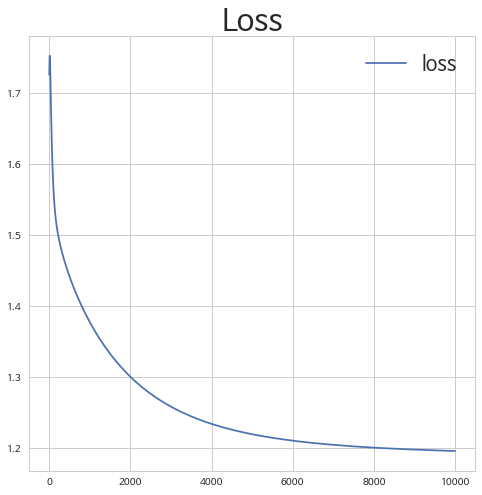

In [11]:
xx = np.linspace(0, n_epoch, num=n_epoch)
plt.figure(figsize=(8, 8))
plt.plot(xx, loss_list, label='loss')
plt.legend(fontsize=20)
plt.title('Loss', fontsize=30)
plt.show()

In [14]:
vector = word2vec.i2h.weight.data.numpy()

In [20]:
idx_list = sorted([(w, i) for w, i in word2vec.vocab2idx.items()], key=itemgetter(1))
idx_list = [t[0] for t in idx_list]
df = pd.DataFrame(vector, index=idx_list).T

In [22]:
df.T.to_csv('vector_cbow.tsv', sep='\t')

In [23]:
df

,NULL,the,king,loves,queen,dwarf,hates,poisons
0,0.0,-0.876403,0.583501,0.976944,0.42687,1.052745,1.751888,0.059861
1,0.0,1.790315,-0.705287,-0.965810,0.26354,-1.788096,-0.211774,0.476756


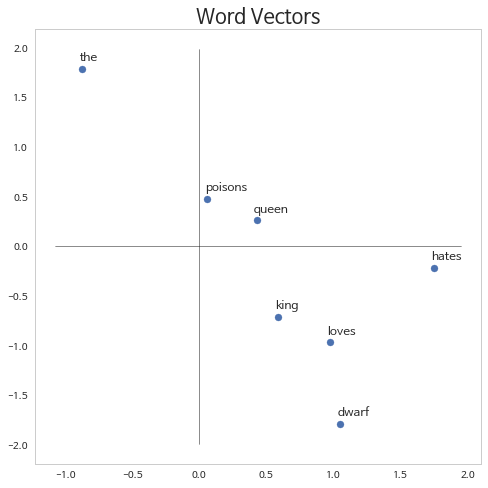

In [40]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(df.values[0, 1:], df.values[1, 1:])
ax.grid(False)
ax.plot((df.values[0, 1:].max()+0.2, df.values[0, 1:].min()-0.2), (0, 0), 'k-', linewidth=0.5)
ax.plot((0, 0), (df.values[1, 1:].max()+0.2, df.values[1, 1:].min()-0.2), 'k-', linewidth=0.5)
plt.title('Word Vectors', fontsize=20)
for i, txt in enumerate(df.columns[1:]):
    ax.annotate(txt, (df.values[0, 1:][i] - 0.02, 
                      df.values[1, 1:][i] + 0.08))

Similarity

In [49]:
from scipy.spatial.distance import cosine

In [59]:
def cosine_similarity(word1, word2, df):
    v_1 = df[word1].values
    v_2 = df[word2].values
    return cosine(v_1, v_2)

In [60]:
cosine_similarity('king', 'queen', df)

0.86235813796520233